In [1]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.io, cv2

# Find images path
images_paths = glob('../Dataset_Final/jpg_images/*/*')

# Fulfill data
X_ = []
y_ = []
for path in images_paths:
    scene = path.split('/')[-2]
    
    # Input data (images)
    img = plt.imread(path)
    # Image resize
    if 1:
        #img = cv2.resize(img, dsize = None,fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
        img = cv2.resize(img, dsize =(256,256), interpolation=cv2.INTER_CUBIC)
        X_.append(img)
    else:
        X_.append(img[0:256,0:256,:])

        X_.append(img[500:500+256,500:500 + 256,:])
        X_.append(img[1000:1000+256,1000:1000 + 256,:])

    # Output data (NLFs)
    nlf_path = '../Dataset_Final/NLFs/NLF_' + scene + '.mat'
    mat = scipy.io.loadmat('../Dataset_Final/NLFs/NLF_' + scene + '.mat')

    NLF = mat["NLF"][0]
    #y_.append(np.nan_to_num(NLF))
    y_.append(np.nan_to_num(NLF[0:256]))
    
#(X_train, y_train), (X_test, y_test) = ''

In [2]:
X_ = np.asarray(X_)
y_ = np.asarray(y_)


In [3]:
print(np.shape(X_))

(523, 256, 256, 3)


### Crear modelo

In [4]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Reshape
from keras.layers import concatenate, AveragePooling2D, Activation, BatchNormalization
from keras.models import Model
from SpatialPyramidPooling import SpatialPyramidPooling
import keras
# First, define the vision modules
input_imgs = Input(shape=(None, None, 3))

# Model
def get_model_column(ks_1, ks_2,p_):
    x = Conv2D(64, kernel_size=(ks_1,ks_1), strides = 2, activation=None)(input_imgs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x) # pool2_a
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    out = keras.layers.ZeroPadding2D(padding=((p_, 0), (0, p_)), data_format=None)(x)
    #out1 = Flatten()(x)
    return out

vision_model1 = Model(input_imgs, get_model_column(5, 3,0))
vision_model2 = Model(input_imgs, get_model_column(7, 5,5))
vision_model3 = Model(input_imgs, get_model_column(9, 7,10))

# Then define the input-apart model
input_a = Input(shape=(256, 256, 3))
input_b = Input(shape=(256, 256, 3)) #shape=(300, 300, 3))
input_c = Input(shape=(256, 256, 3)) #shape=(340, 340, 3))

# The vision model will be shared, weights and all
out_a = vision_model1(input_a)
out_b = vision_model2(input_b)
out_c = vision_model3(input_c)

concatenated = concatenate([out_a, out_b, out_c],axis=-1)
#out = Dense(1, activation='sigmoid')(concatenated)
merge_abc = SpatialPyramidPooling([1, 2, 4])(concatenated)
#merge_abc = Dense(2048, activation='relu')(merge_abc)
#merge_abc = Dense(256*3, activation='relu')(merge_abc)
#merge_abc = Flatten()(concatenated)
merge_abc = Dense(2048, activation='relu')(merge_abc)
merge_abc = Dense(256, activation='relu')(merge_abc)

model_abc = Model([input_a, input_b, input_c], merge_abc)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model_abc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 multiple             116672      input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (M

### Training

In [6]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.001, decay=0.0001, momentum=0.9, nesterov=True)

# compile model (abc)
model_abc.compile(optimizer= sgd, loss='mse')

In [7]:
# Make model_a non trainable
model_abc.layers[3].trainable = False
model_abc.layers[4].trainable = False
model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=20, validation_split=0.2, shuffle=True)

# Make model_a non trainable
model_abc.layers[3].trainable = False
model_abc.layers[4].trainable = True
model_abc.layers[5].trainable = False
model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=20, validation_split=0.2, shuffle=True)

# Make model_a non trainable
model_abc.layers[3].trainable = True
model_abc.layers[4].trainable = False
model_abc.layers[5].trainable = False
model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=20, validation_split=0.2, shuffle=True)


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/home/plyzer-ai/anaconda3/envs/carlus/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 418 samples, validate on 105 samples
Epoch 1/20
418/418 [==============================] - 6s 13ms/step - loss: 0.6474 - val_loss: 24.3061
Epoch 2/20
418/418 [==============================] - 1s 3ms/step - loss: 0.0159 - val_loss: 18.2306
Epoch 3/20
418/418 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 16.2287
Epoch 4/20
418/418 [==============================] - 1s 3ms/step - loss: 5.2091e-04 - val_loss: 15.3548
Epoch 5/20
418/418 [==============================] - 1s 3ms/step - loss: 2.4665e-04 - val_loss: 14.9398
Epoch 6/20
418/418 [==============================] - 1s 3ms/step - loss: 1.9336e-04 - val_loss: 14.7323
Epoch 7/20
418/418 [==============================] - 1s 3ms/step - loss: 1.8046e-04 - val_loss: 14.6277
Epoch 8/20
418/418 [==============================] - 1s 4ms/step - loss: 1.7917e-04 - val_loss: 14.5747
Epoch 9/20
418/418 [==============================] - 2s 4ms/step - loss: 1.7973e-04 - val_loss: 14.5440
Epoch 10/20
418/418 

In [8]:

(model_abc.predict([[X_[0]],[X_[0]],[X_[0]]]))

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  4.7353597 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         3.429306  ,  6.1703215 ,  0.        ,  0.        ,  0.        ,
        16.767918  ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 16.530386  ,  0.        ,
         0.        ,  0.        , 10.890695  ,  0.        ,  0.        ,
         0.        ,  0.        ,  2.2380967 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  6.009605  ,  0.3678988 ,  0.        ,  0.        ,
         0.        , 12.111576  ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

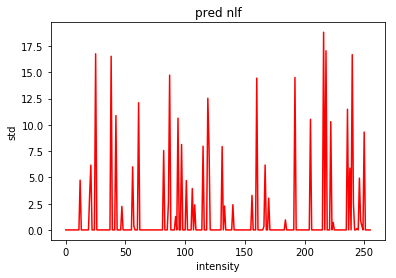

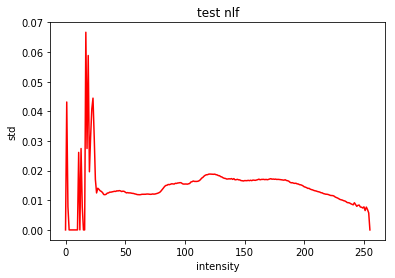

In [9]:
import matplotlib.pyplot as plt
y_pred = np.transpose(model_abc.predict([[X_[1,0:256,0:256,:]],[X_[1,0:256,0:256,:]],[X_[1,0:256,0:256,:]]]))

fig, ax = plt.subplots()
ax.plot(y_pred[0:256],'r')

ax.set(xlabel='intensity', ylabel='std',
       title='pred nlf')
plt.show()

fig, ax = plt.subplots()
ax.plot(y_[1][0:256],'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf')
plt.show()

In [10]:
'''from keras.utils import plot_model

plot_model(model_abc, to_file='model_plot.png', show_shapes=True, show_layer_names=True)'''


"from keras.utils import plot_model\n\nplot_model(model_abc, to_file='model_plot.png', show_shapes=True, show_layer_names=True)"

In [11]:
'''from keras import backend as K
K.tensorflow_backend._get_available_gpus()'''

'from keras import backend as K\nK.tensorflow_backend._get_available_gpus()'

In [12]:
model_abc.save('models/model_abc1704.h5')